In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import random
%matplotlib inline

# Define Units

Energy: MeV  
Mass:   MeV * c$^2$  
Time:   s  
Length: m   
Angles: Radians  

# Define Constants

In [2]:
alpha = 1/137
r_o = 2.81794e-15 #m
m_p = 938.272 #MeV/c^2
m_e = .511 #MeV/c^2
m_pi = 134.9766 #MeV/c^2
q = 1.6e-19
h = 4.136e-21 #MeV*s 
c  = 3e8
N_A = 6.022e23
rho = 916.7 #kg/m^3 at 0C and atmospheric pressure
Z_nuc = 7.42 #Z_eff for water
A_r = Z_nuc/.55509 #Z/A = .55509
n = 1.309 #index of refraction of ice
X_o = 1/(4*alpha*(r_o**2)*rho*(N_A/A_r)*Z_nuc*(1+Z_nuc)*np.log(183/(Z_nuc**(1/3))))
print(X_o)
print(A_r)
X_1 = 1433/(.916)*A_r/(Z_nuc*(Z_nuc+1)*(11.319-np.log(Z_nuc))) / 100.
X_o = X_1
print(X_1)

detection_radius = .3 #half of the hole width

368.096194824722
13.367201715037202
0.3593359848217181


# Define different Particles

In [3]:
class Particle: 
    def __init__(self, particle_type, mass, charge, direction, location, energy):
        self.particle_type = particle_type
        self.mass = mass
        self.charge = charge
        self.location = location # array of [x, y, z] to describe location
        self.direction = direction # array of [theta, phi] in direction of travel
        self.theta = self.direction[0]
        self.phi = self.direction[1]
        self.energy = energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c #get rid of c?
        
    def update_energy(self, new_energy):
        self.energy = new_energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c #get rid of c?

## Define Detector

In [4]:
class DOM:
    def __init__(self, location):
        self.location = location
        self.triggered = False
        
    def distance_from(self, location): 
        x = location[0]
        y = location[1]
        z = location[2]
        dom_x = self.location[0]
        dom_y = self.location[1]
        dom_z = self.location[2]
        return np.sqrt((dom_x - x)**2 + (dom_y - y)**2 + (dom_z - z)**2)
    
class detector:
    def __init__(self, dom_list):
        self.dom_list = dom_list
        
    def num_triggered(self): 
        num_triggered = 0
        for dom in dom_list: 
            if dom.triggered: 
                num_triggered += 1
        return num_triggered

## Define Coordinates

In [5]:
#We assume that the center of IceCube is at [x,y,z] = [0,0,0]

def conv_spherical_to_cartesian(r, theta, phi):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return(x,y,z)

def conv_cartesian_to_spherical(x,y,z):
    r = np.sqrt(x**2+y**2+z**2) #distance to center of IceCube
    theta = np.arccos(z/np.sqrt(x**2+y**2+z**2))
    phi = np.arctan(y/x)
    return(r, theta, phi)

def add_direction(theta_i, phi_i, theta_step, phi_step):
    x_i, y_i, z_i = conv_spherical_to_cartesian(1, theta_i, phi_i)
    x_step, y_step, z_step = conv_spherical_to_cartesian(1, theta_step, phi_step)
    x_f = x_i + x_step
    y_f = y_i + y_step
    z_f = z_i + z_step
    r_f, theta_f, phi_f = conv_cartesian_to_spherical(x_f,y_f,z_f)
    return([theta_f, phi_f])


# Monte Carlo the Cascade

Take each interaction, consider governing equations, pick randomized variables to plug into those equations

## Functions for kinematics

In [6]:
#interact & define secondaries

def em_shower_step(particle):   
    if particle.particle_type == 'electron':
        #move
        dx, dy, dz = conv_spherical_to_cartesian(X_o, particle.theta, particle.phi)
        particle.location = [particle.location[0]+dx,particle.location[1]+dy,particle.location[2]+dz]

        #interact & define secondaries
        phi_i = random.uniform(0,np.pi)
        pair_prod = 0; bremss=1;
        interaction = random.randint(0,1)  #include probabilities later
        if interaction == pair_prod: #assuming it hits a positron at rest
            #print('pp')
            photon_energy = (particle.energy+particle.mass)/2
            direction1_step = [np.arccos(np.sqrt((particle.energy**2-particle.mass**2)/2*(photon_energy/c)**2)), phi_i]
            direction2_step = [-np.arccos(np.sqrt((particle.energy**2-particle.mass**2)/2*(photon_energy/c)**2)), np.pi-phi_i]
            direction1 = add_direction(particle.theta, particle.phi, direction1_step[0], direction1_step[1])
            direction2 = add_direction(particle.theta, particle.phi, direction2_step[0], direction2_step[1])
            photon1 = Particle('photon', 0, 0, direction1, particle.location, photon_energy) 
            photon2 = Particle('photon', 0, 0 , direction2, particle.location, photon_energy)
            return(photon1,photon2)  
        elif interaction == bremss:
            #print('bremss')
            photon_momentum = particle.energy/(2*c) #get rid of c?
            secondary_electron_momentum = np.sqrt((particle.energy/2)**2 - m_e**2)/c #get rid of c?
            electron_direction_step = [np.arccos((particle.momentum**2-photon_momentum**2)/(2*particle.momentum*secondary_electron_momentum)), phi_i]
            electron_direction = add_direction(particle.theta, particle.phi, electron_direction_step[0], electron_direction_step[1])
            photon_direction = [np.arcsin(np.sin(electron_direction_step[0])*secondary_electron_momentum/photon_momentum),np.pi - phi_i]
            #print(electron_direction)
            #print(photon_direction)
            electron_energy = particle.energy/2
            photon = Particle('photon', 0, 0, photon_direction, particle.location, (particle.energy)/2) 
            secondary_electron = Particle('electron',m_e,-1,electron_direction, particle.location, electron_energy)
            return(secondary_electron, photon)
    if particle.particle_type=='photon':
        #move
        dx, dy, dz = conv_spherical_to_cartesian(X_o, particle.theta, particle.phi)
        particle.location = [particle.location[0]+dx,particle.location[1]+dy,particle.location[2]+dz]

        #interact & define secondaries for pair production
        phi_i = random.uniform(0,np.pi)
        electron_energy = particle.energy/2
        #direction1_step = [np.arccos(particle.energy/(2*np.sqrt(electron_energy**2-(m_e**2)))), phi_i] #BROKEN
        #direction2_step = [-np.arccos(particle.energy/(2*np.sqrt(electron_energy**2-(m_e**2)))), np.pi-phi_i] #BROKEN
        #direction1 = add_direction(particle.theta, particle.phi, direction1_step[0], direction1_step[1]) #BROKEN
        #direction2 = add_direction(particle.theta, particle.phi, direction2_step[0], direction2_step[1]) #BROKEN
        direction1 = particle.direction #temporary
        direction2 = particle.direction #temporary
        #print(particle.energy/(2*np.sqrt(electron_energy**2-(m_e**2))))
        #print(direction2)
        electron = Particle('electron', .511, -1, direction1, particle.location, electron_energy)
        positron = Particle('positron', .511, 1 , direction2, particle.location, electron_energy)
        return(electron,positron)                     

## Functions for Cherenkov radiation

In [7]:
from scipy.spatial import ConvexHull
from cycler import cycler

In [8]:
# Convex Hull options

# '_add_points',
#  '_points',
#  '_qhull',
#  '_update',
#  '_vertices',
#  'add_points',
#  'area',
#  'close',
#  'coplanar',
#  'equations',
#  'good',
#  'max_bound',
#  'min_bound',
#  'ndim',
#  'neighbors',
#  'npoints',
#  'nsimplex',
#  'points',
#  'simplices',
#  'vertices',
#  'volume'

In [9]:
# Stealing stuff from Zingale as per usual
# This time its the rainbow plotting code

## Define RGBA to HEX
def rgba_to_hex(rgba):
    r = int(rgba[0]*255.0)
    g = int(rgba[1]*255.0)
    b = int(rgba[2]*255.0)
    return '#{:02X}{:02X}{:02X}'.format(r,g,b)

# Get color map
rainbow_cm = plt.get_cmap('nipy_spectral')
def color_map(n):
    # n = number of colors in the rainbow spectrum to return
    clist = [rainbow_cm(1.0*i/n) for i in range(n)]
    return [rgba_to_hex(ci) for ci in clist]

In [10]:
class VisibilityRegion:
    """
    Class representing the region in which a photon can be observed by a DOM along its path
    
    Parameters
    ----------
    step_positions: list
        List of dictionaries of structure
        {'location': float, 'direction': {'theta': float,  'phi': float}}
        where the location is the photon location and theta/phi describe the
        direction in which the photon is traveling
    viewable_radius: float
        distance from the photon location that the photon can be viewed from
        recommendation: radius of a DOM
    
    Attributes
    ----------
    regions: list
        List of Scipy ConvexHulls representing the photon's path, 
        incorporating the viewable_radius. 
    
    """
    
    def __init__(self, step_positions, viewable_radius):
        # Step positions is a list of dictionaries with keys: location, direction (theta/phi?)
        self.step_positions    = step_positions
        self.viewable_radius   = viewable_radius
        
        self.regions = []
        for i, step in enumerate(self.step_positions):
            if i == len(self.step_positions)-1: 
                continue
            else: 
                self.regions.append(ConvexHull(np.vstack((
                    self.create_circle(step['location'], 
                                       step['direction']['theta'], 
                                       step['direction']['phi']) ,
                    self.create_circle(self.step_positions[i+1]['location'], 
                                       self.step_positions[i+1]['direction']['theta'], 
                                       self.step_positions[i+1]['direction']['phi'] )
                ))))
                
    def create_circle(self, vtx, theta, phi):
        """
        Circle centered on the photon pointing in its direction of travel
        and oriented in the photon travel direction
        
        Parameters
        ----------
        vtx: float
            The 3D location position of the center of the circle
        theta: float
            The angle in zenith by which the circle is tilted. 0 = straight up
        phi: float
            The angle in azimuth by which the circle is rotated. 
        
        Returns
        ----------
        ndarray
            A numpy array of 3D coordinates for a circle of radius viewable_radius 
            with its center at vtx oriented by theta in zenith and phi azimuthally
        """
        
        # Generic circle in x-y plane (at z = 0)
        circle_thetas = np.linspace(0, 2*np.pi, 50)
        circle = np.array([
            self.viewable_radius * np.cos(circle_thetas),
            self.viewable_radius * np.sin(circle_thetas),
            [0]*len(circle_thetas),
        ]).T
        x = circle[:,0]; y = circle[:,1]; z = circle[:,2]
        
        # Manipulating and returning generic circle
        cos_t = np.cos(np.radians(theta)); sin_t = np.sin(np.radians(theta))
        cos_p = np.cos(np.radians(phi));   sin_p = np.sin(np.radians(phi))
        return np.array([
                    # R_z * R_x
#                     (x*cos_p - y*sin_p*cos_t + z*sin_p*sin_t) + vtx[0],
#                     (x*sin_p + y*cos_p*cos_t - z*cos_p*sin_t) + vtx[1],
#                                           (y*sin_t + z*cos_t) + vtx[2] 
                    # R_x * R_z
                                          (x*cos_p + y*sin_p) + vtx[0],
                    (x*cos_t*sin_p + y*cos_t*cos_p - z*sin_t) + vtx[1],
                    (x*sin_t*sin_p + y*sin_t*cos_p + z*cos_t) + vtx[2] 
                ]).T
                
        
    def contains(self, point): 
        """
        Determines if the provided point is within the photon viewability region
        
        Parameters
        ----------
        point: array
            array of format [x, y, z] defining a 3D point
        
        Returns
        ----------
        boolean
            True if the point is along the photon's path and within the photon's
            viewability region. 
            False otherwise
        """
        
        for region in self.regions:
            # From https://stackoverflow.com/questions/29311682/finding-if-point-is-in-3d-poly-in-python
            test_region = ConvexHull(
                np.concatenate((region.points, [point]))
            )
            if np.array_equal(test_region.vertices, region.vertices): 
                return True
        return False
        
    def show(self, x_axis='x', y_axis='y'): 
        """
        Prints to screen the photon path according to the specified axes
        
        Parameters
        ----------
        x_axis: str
            Photon travel axis to plot on the plot's X-Axis. 'x' if plotting 
            photon x-path on plot's x-axis. Options: 'x', 'y', 'z'
        y_axis: str
            Photon travel axis to plot on the plot's Y-Axis. 'z' if plotting 
            photon z-path on plot's y-axis. Options: 'x', 'y', 'z'
        
        Returns
        ----------
        None
        """
        
        axis_index = {'x':0, 'y':1, 'z':2}
#         ax.set_prop_cycle(cycler('color', hexclist))
        colors = color_map(len(self.regions))
        x_min = None; x_max = None
        y_min = None; y_max = None
        for i, region in enumerate(self.regions):
            x_vals = region.points[region.vertices, axis_index[x_axis]]
            y_vals = region.points[region.vertices, axis_index[y_axis]]
            plt.scatter(x_vals, y_vals, color=colors[i])
            
#             if x_max == None or np.max(x_vals) > x_max: 
#                 x_max = np.max(x_vals)
#             if x_min == None or np.min(x_vals) > x_min: 
#                 x_min = np.min(x_vals)
#             if y_max == None or np.max(y_vals) > y_max: 
#                 y_max = np.max(y_vals)
#             if y_min == None or np.min(y_vals) > y_min: 
#                 y_min = np.min(y_vals)
                
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.show()
        return None

In [11]:
shape = VisibilityRegion(
    step_positions = [
    {'location': [0,0,0], 'direction':{'theta': 0, 'phi':0}},
    {'location': [0,0,2], 'direction':{'theta': 135, 'phi':0}}, 
    {'location': [0,2,4], 'direction':{'theta': 90, 'phi':0}},
    {'location': [0,4,4], 'direction':{'theta': 90, 'phi':0}},
#     {'location': [0,4,8], 'direction':{'theta': 45, 'phi':0}},
#     {'location': [0,6,10], 'direction':{'theta': 90, 'phi':0}},
#     {'location': [0,8,12], 'direction':{'theta': 90, 'phi':0}},
                  ], 
    viewable_radius = 1)

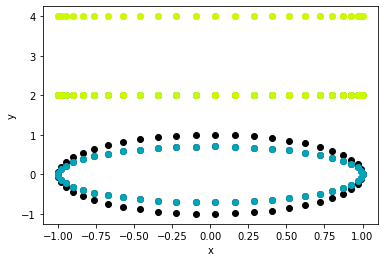

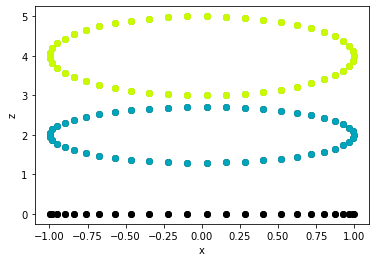

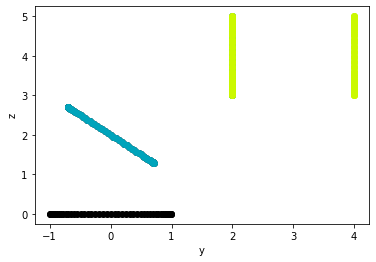

In [12]:
shape.show(x_axis = 'x', y_axis = 'y')
shape.show(x_axis = 'x', y_axis = 'z')
shape.show(x_axis = 'y', y_axis = 'z')

In [13]:
shape.contains([0,1.5,0.5])

False

In [14]:
def random_walk(photon, n_steps, detector, plot_step=False):
    
    photon_steps = [{'location': photon.location, 
                     'direction': {'theta': photon.theta,  'phi': photon.phi}}]
    for step in range(n_steps):
        absorption = random.random()
        if absorption <= .2: #make this more realistic
            break
       
        #random walk for scattering
        move_theta = math.pi * random.random()   #does this need to be more realistic
        move_phi = 2*math.pi * random.random()
        new_theta = add_direction(photon_steps[-1]['direction']['theta'],
                                  photon_steps[-1]['direction']['phi'],
                                  move_theta, move_phi)[0]
        new_phi = add_direction(photon_steps[-1]['direction']['theta'],
                                photon_steps[-1]['direction']['phi'],
                                move_theta, move_phi)[1]
        
        dx, dy, dz = conv_spherical_to_cartesian(X_o, new_theta, new_phi)
        new_loc = [photon_steps[-1]['location'][0]+dx,
                   photon_steps[-1]['location'][1]+dy,
                   photon_steps[-1]['location'][2]+dz]
        photon_steps.append({'location': new_loc, 
                             'direction': {'theta': new_theta,  'phi': new_phi}})
        photon.direction = [new_theta, new_phi] 
        photon.theta = new_theta
        photon.phi = new_phi
        photon.location = new_loc
        
        #Determine if DOM is within visibility region / if a DOM triggers
        visibility_region = VisibilityRegion(photon_steps[-2:], detection_radius)
        
        # Determine if DOMs trigger
        for dom in detector.dom_list:   
            if visibility_region.contains(dom.location): 
                # TODO: Add a probability variable that the DOM triggers, currently 100% efficiency
                dom.triggered = True
                break
            else: 
                continue
        break
    
    if plot_step: 
        print(photon_steps[0]['location'][2], photon_steps[-1]['location'][2])
        visibility_region = VisibilityRegion(photon_steps, detection_radius)
        visibility_region.show()
    
        
        #WE DON'T NEED THIS UNLESS IF X_o >= DOM spacing
        # Only trigger the DOM closest to the particle
#         if len(triggered_DOMs) > 1: 
#             closest_dom = triggered_DOMs[0]
#             closest_distance = triggered_DOMs[0].distance_from(charged_particle.location) #is this ok w/ rw
#             for dom in triggered_DOMs: 
#                 if dom.distance_from(charged_particle.location) < closest_distance: #is this ok w/ rw
#                     closest_dom = dom
#                     closest_distance = dom.distance_from(charged_particle.location) #is this ok w/ rw
#             closest_dom.triggered = True
#         elif len(triggered_DOMs) == 1: 
#             triggered_DOMs[0].triggered = True
    return detector

In [15]:
def cherenkov(charged_particle,n_steps,random_walk_n_steps, detector): 
    #make cone & see if it intersects w/ detector, 
    # return every Cherenkov photon & its path
    angle = np.arccos(1/(n*charged_particle.beta))
    dNdx = (2*math.pi*(charged_particle.charge**2)
            *alpha*(np.sin(angle)**2)*((1/(400e-9))-(1/(700e-9))))
    N = dNdx * X_o #assuming the electron travels 1 radiation length as it emits Cherenkov radiation
    cherenkov_photons = []
    for i in range(n_steps):
        print(f"\t\tSimulating Cherenkov step {i} for {int(N/n_steps)} photons")
        for photon in range(int(N/n_steps)):
            
            if photon % 1000 == 0: 
                print(f"\t\t\tSimulating photon {photon}")
            
            add_angle = add_direction(charged_particle.direction[0],
                                      charged_particle.direction[1], 
                                      angle, 2*np.pi/N * i)
            
            new_photon = Particle('photon', 0, 0, add_angle, 
                                  charged_particle.location, 
                                  h*c/(450e-9)) #assumed blue light
            cherenkov_photons.append(new_photon)
            
            if photon%1000 == 0: 
                detector = random_walk(new_photon, n_steps, detector, plot_step=True)
            else: 
                detector = random_walk(new_photon, n_steps, detector)

            energy_lost = N*h*c/(450e-9)
            charged_particle.update_energy(charged_particle.energy-energy_lost)
    return(N, detector)

# Simulate Shower

In [16]:
def em_shower(neutrino, steps, n_cher_steps, detector, plot_shower=False):
    electron = Particle('electron',m_e,-1,
                        neutrino.direction, neutrino.location, neutrino.energy)
    particle_plotters = [[np.array([neutrino.location, electron.location])]]
    incoming_particles =[electron]
    for n in range(steps):
        print(f"Simulating EM Shower step {n}")
        outgoing_particles = []
        particle_plotters.append([])
        for particle in incoming_particles:
            new_particles = em_shower_step(particle)
            for new_particle in new_particles: 
                particle_plotters[-1].append(np.array([particle.location, 
                                                       new_particle.location]))
            outgoing_particles.append(new_particles[0])
            outgoing_particles.append(new_particles[1])
        for particle in outgoing_particles:
            if particle.charge != 0:
                print(f"\tSimulating Particle {particle.particle_type}")
                N_photons, detector = cherenkov(particle, n_cher_steps, 
                                                2, detector)
        incoming_particles = outgoing_particles
        
    if plot_shower: 
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')
        colors = color_map(len(particle_plotters))
        
        for i, step in enumerate(particle_plotters): 
            for line in step: 
                ax.plot(line[:,0], line[:,1], line[:,2], color=colors[i])
        
        x_min = None; x_max = None
        y_min = None; y_max = None
        for i, region in enumerate(self.regions):
            x_vals = region.points[region.vertices, axis_index[x_axis]]
            y_vals = region.points[region.vertices, axis_index[y_axis]]
            plt.scatter(x_vals, y_vals, color=colors[i])
            
#             if x_max == None or np.max(x_vals) > x_max: 
#                 x_max = np.max(x_vals)
#             if x_min == None or np.min(x_vals) > x_min: 
#                 x_min = np.min(x_vals)
#             if y_max == None or np.max(y_vals) > y_max: 
#                 y_max = np.max(y_vals)
#             if y_min == None or np.min(y_vals) > y_min: 
#                 y_min = np.min(y_vals)
                
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.show()
        return None
        
    return detector

# Running the Simulation

# Create Detector

In [17]:
X, Y, Z = np.mgrid[-20:20:2j, -20:20:2j,-20:20:2j]
locations = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
dom_list = []
for dom in locations:
    dom_list.append(DOM(dom))
IceCube_small = detector(dom_list)    

X, Y, Z = np.mgrid[-500:500:21j, -500:500:21j,-500:500:21j]
locations = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
dom_list = [DOM(loc) for loc in locations]
IceCube = detector(dom_list)

(9261, 3)

# Create Neutrino

In [18]:
neutrino = Particle('electron neutrino', 0, 0, [0, 1, 0], [20, -20.2, 19.5], 1000)

# Simulate the Shower

Simulating EM Shower step 0
	Simulating Particle electron
		Simulating Cherenkov step 0 for 7352 photons
			Simulating photon 0
19.85933598482172 19.85933598482172


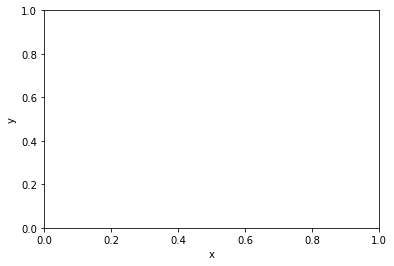

			Simulating photon 1000
19.85933598482172 19.9327571050538


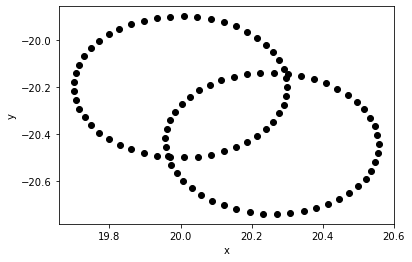

			Simulating photon 2000
19.85933598482172 20.19496872028696


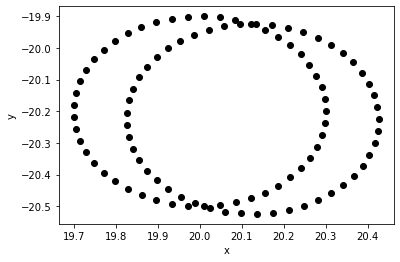

			Simulating photon 3000
19.85933598482172 20.04051542524908


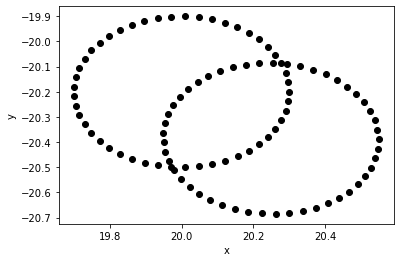

			Simulating photon 4000
19.85933598482172 20.202040665388658


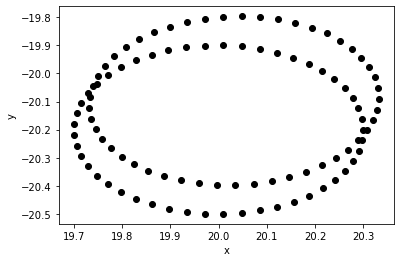

			Simulating photon 5000
19.85933598482172 20.018391817531096


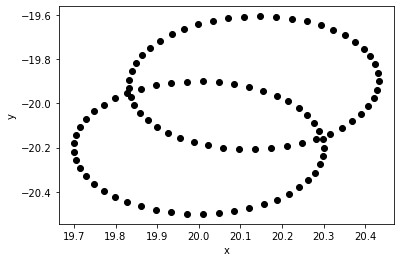

			Simulating photon 6000
19.85933598482172 20.174393461562484


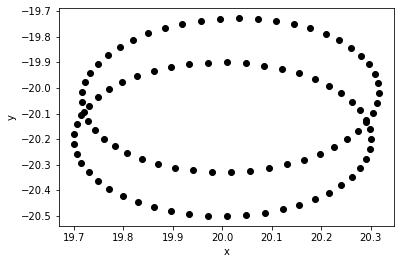

			Simulating photon 7000
19.85933598482172 19.723126402459883


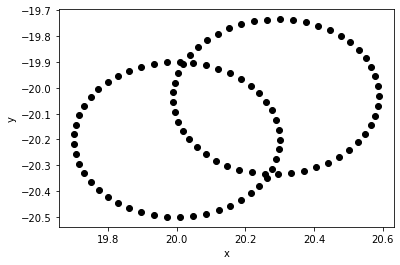

In [164]:
IceCube = em_shower(neutrino, 1, 1, IceCube_small)

In [165]:
num_triggered = 0
for dom in IceCube.dom_list:
    if dom.triggered:
        num_triggered += 1
num_triggered

1

# Ananlyze Detector Response

In [19]:
def plot_event(neutrino, detector, 
               title='', filename=None, step=1, show_full_detector=False,
               debug=False):

    hits_pos = [] # doms that trigger
    other_pos = [] # doms that dont
    
    if debug:
        print()
        print(event.get_particle_info()[0])
        
    loc = neutrino.location
    dirn = neutrino.direction
    
    for dom in detector.dom_list:
        if dom.triggered:
            hits_pos.append(dom.location)
        else:
            other_pos.append(dom.location)
    if debug:
        print(*list(hits_pos), sep='\n')
    hits_pos = np.array(hits_pos)
    other_pos = np.array(other_pos)
      
    # plotting the data
    for angle in range(0, 360, step):
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot hits
        hits = ax.scatter(hits_pos[:, 0], hits_pos[:, 1], hits_pos[:, 2], 
                          marker='o', c='r', s=20)
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        dim = max([xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]])
        x = np.mean(xlim)
        y = np.mean(ylim)
        z = np.mean(zlim)
        xlim = [max(x-dim/2, -600), min(x+dim/2, 600)]
        ylim = [max(y-dim/2, -600), min(y+dim/2, 600)]
        zlim = [max(z-dim/2, -600), min(z+dim/2, 600)]
        
        # Plot non-hits
        if show_full_detector: 
            ax.scatter(other_pos[:, 0], other_pos[:, 1], other_pos[:, 2],
                       marker='o', s=10, c='b')
        else: 
            plot_pos = []
            for pos in other_pos:
                if (xlim[0]<pos[0]<xlim[1] and ylim[0]<pos[1]<ylim[1] 
                    and zlim[0]<pos[2]<zlim[1]):
                    plot_pos.append(pos)
            if len(plot_pos) != 0: 
                plot_pos = np.array(plot_pos)
                ax.scatter(plot_pos[:, 0], plot_pos[:, 1], plot_pos[:, 2],
                           marker='o', s=10, c='b')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_zlim(zlim)
        
        # Plot vertex and rays
        ax.scatter(*loc, marker='o', s=10, c='k')
        ax.quiver(*loc, *dirn, color='k', length=100)

        ax.view_init(30, angle)
        
        plt.title(title)
        if filename is not None:
            plt.tight_layout()
            plt.savefig(filename+'_'+str(angle).zfill(3)+'.png', dpi=200)
        if angle%90==45-(45%step):
            plt.show()
        plt.close()

In [22]:
IceCube_small.dom_list[0].triggered=True
IceCube_small.dom_list[1].triggered=True
IceCube_small.dom_list[2].triggered=True

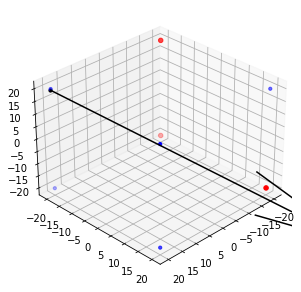

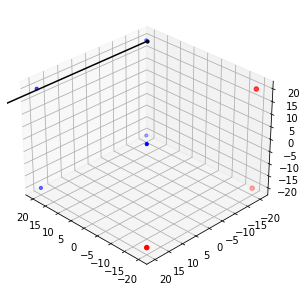

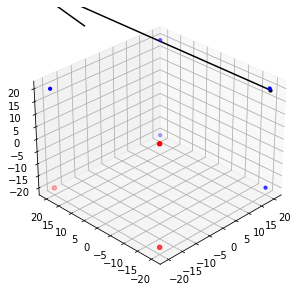

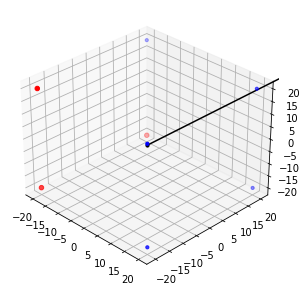

In [24]:
plot_event(neutrino, IceCube_small, show_full_detector=True)